### imports

In [23]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os
import yfinance as yf
from finta import TA
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import StandardScaler
import hvplot.pandas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC  
import matplotlib.pyplot as plt
%matplotlib inline

### Initializers

### Download data from yfinance

In [24]:
# Downloaded 2 years worth of hourly data from yfinance for features used to train ML model and filled NaN with the data from the last row.
indicator_tickers = ['^TNX','^IRX','DX-Y.NYB','SPY','ETH-USD']
yf_data = yf.download(
    indicator_tickers, 
    period='7y', 
    interval='1d', 
    ignore_tz = False, 
    prepost = True, 
    parse_dates=True, 
    infer_datetime_format=True, 
    tz = 'utc'
)['Adj Close']
    
yf_data.fillna(method='pad', inplace=True)
yf_data

[*********************100%***********************]  5 of 5 completed


,DX-Y.NYB,ETH-USD,SPY,^IRX,^TNX
Date,,,,,
2015-11-16 05:00:00+00:00,99.440002,NaN,NaN,0.098,2.273
2015-11-17 05:00:00+00:00,99.629997,NaN,180.916077,0.135,2.261
2015-11-18 05:00:00+00:00,99.650002,NaN,183.786560,0.123,2.269
2015-11-19 05:00:00+00:00,98.989998,NaN,183.628036,0.088,2.248
2015-11-20 05:00:00+00:00,99.570000,NaN,184.297211,0.093,2.262
...,...,...,...,...,...
2022-11-14 05:00:00+00:00,106.660004,1241.604248,395.119995,4.068,3.865
2022-11-15 00:00:00+00:00,106.660004,1251.736206,395.119995,4.068,3.865
2022-11-15 05:00:00+00:00,106.400002,1251.736206,398.489990,4.130,3.799


### Adding Leading Indicators (features for ML)

In [25]:
# Adding possible leading indicator columns for pct change & yield curves of 10 year and 2 year US Treasury bonds.
yf_data['UST_curve'] = yf_data['^TNX'] - yf_data['^IRX']

# Removing columns that will not be used.

yf_data

,DX-Y.NYB,ETH-USD,SPY,^IRX,^TNX,UST_curve
Date,,,,,,
2015-11-16 05:00:00+00:00,99.440002,NaN,NaN,0.098,2.273,2.175
2015-11-17 05:00:00+00:00,99.629997,NaN,180.916077,0.135,2.261,2.126
2015-11-18 05:00:00+00:00,99.650002,NaN,183.786560,0.123,2.269,2.146
2015-11-19 05:00:00+00:00,98.989998,NaN,183.628036,0.088,2.248,2.160
2015-11-20 05:00:00+00:00,99.570000,NaN,184.297211,0.093,2.262,2.169
...,...,...,...,...,...,...
2022-11-14 05:00:00+00:00,106.660004,1241.604248,395.119995,4.068,3.865,-0.203
2022-11-15 00:00:00+00:00,106.660004,1251.736206,395.119995,4.068,3.865,-0.203
2022-11-15 05:00:00+00:00,106.400002,1251.736206,398.489990,4.130,3.799,-0.331


In [26]:
yf_data = yf_data.drop(columns=['^IRX', 'ETH-USD'])

In [27]:
# Setting the crypto that we want to trade
target_crypto = 'ETH-USD'
# Pulling in data from yfinance for target crypto
target_df = yf.download(
    target_crypto, 
    period='7y', 
    interval='1d', 
    ignore_tz = False, 
    prepost = True, 
    parse_dates=True, 
    infer_datetime_format=True, 
    tz = 'utc'
)
# Add ta features 
target_df['RSI'] = target_df.ta.rsi(length=14)
target_df['ATR'] = ta.atr(target_df.High, target_df.Low, target_df.Close, length=20)
target_df['Short EMA'] = ta.ema(target_df.Close, length=5)
target_df['Med EMA'] = ta.ema(target_df.Close, length=21)
target_df['Long EMA'] = ta.ema(target_df.Close, length=63)                       
target_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,Short EMA,Med EMA,Long EMA
Date,,,,,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,320.884003,893249984,NaN,NaN,NaN,NaN,NaN
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,NaN,NaN,NaN,NaN,NaN
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,NaN,NaN,NaN,NaN,NaN
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,NaN,NaN,NaN,NaN,NaN
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,NaN,NaN,311.888397,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12 00:00:00+00:00,1287.438354,1288.150879,1242.152222,1255.268311,1255.268311,10964962767,40.800733,92.397345,1301.602273,1412.060935,1435.261385
2022-11-13 00:00:00+00:00,1255.441284,1271.712524,1208.520996,1221.819214,1221.819214,10717455214,39.292944,90.937054,1275.007920,1394.766233,1428.591317
2022-11-14 00:00:00+00:00,1221.895508,1284.217651,1178.429077,1241.604248,1241.604248,15028035663,40.689132,91.679630,1263.873363,1380.842417,1422.747971


In [28]:
# Created the gunction to buy and sell
def buy_sell_function(data):
    
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False
    
    for i in range(0, len(data)):
        if data['Med EMA'][i] < data['Long EMA'][i] and data['Short EMA'][i] < data['Med EMA'][i] and flag_long == False:
            buy_list.append(data['Close'][i])
            sell_list.append(0)
            flag_short = True
        elif flag_short == True and data['Short EMA'][i] > data['Med EMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(0)
            flag_short = False
        elif data['Med EMA'][i] > data['Long EMA'][i] and data['Short EMA'][i] > data['Med EMA'][i] and flag_long == False:
            buy_list.append(data['Close'][i])
            sell_list.append(0)
            flag_short = True
        elif flag_long == True and data['Short EMA'][i] < data['Med EMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(0)
            flag_short = False
        else:
            buy_list.append(0)
            sell_list.append(0)
    return (buy_list, sell_list)

In [29]:
# Add the buy and sell signals to the data set
target_df['Buy'] = buy_sell_function(target_df)[0]
target_df['Sell'] = buy_sell_function(target_df)[1]

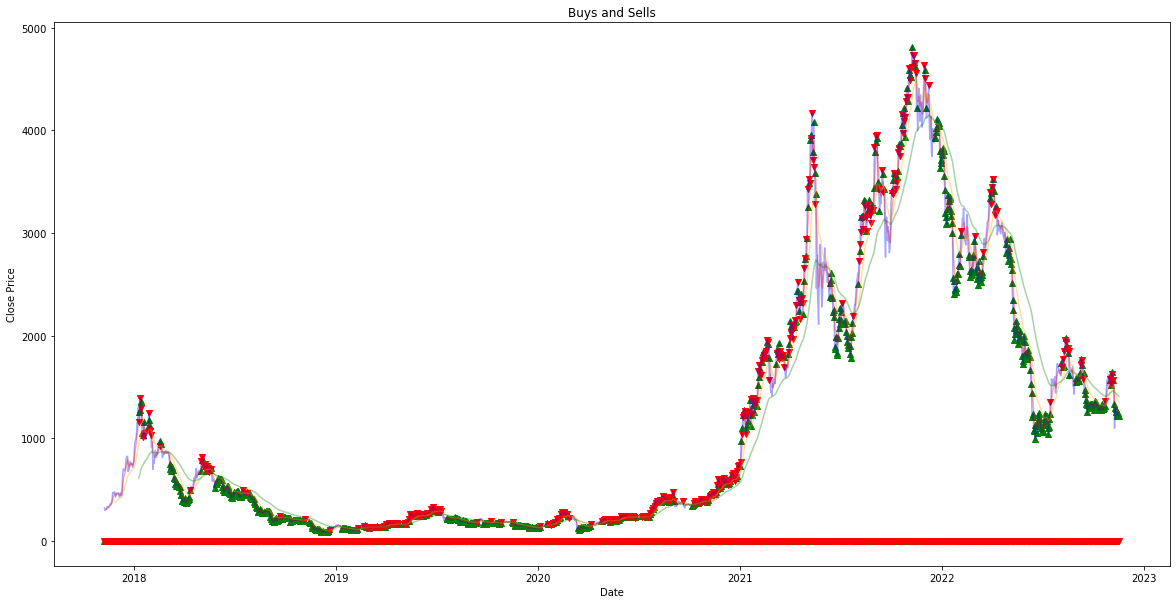

In [30]:
# Visually show the buy and sell signals
plt.figure(figsize=(20, 10))
plt.title('Buys and Sells')
plt.plot(target_df['Close'], label='Close Price', color='blue', alpha=0.35)
plt.plot(target_df['Short EMA'], label='Short/Fast EMA', color='red', alpha=0.35)
plt.plot(target_df['Med EMA'], label='Medium/Mid EMA', color='orange', alpha=0.35)
plt.plot(target_df['Long EMA'], label='Long/Slow EMA', color='green', alpha=0.35)
plt.scatter(target_df.index, target_df['Buy'], color='green', marker='^', alpha=1)
plt.scatter(target_df.index, target_df['Sell'], color='red', marker='v', alpha=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [32]:
# Dropping the columns that we don't need from the target DataFrame
# Adj Close column is what we want to predict with the ML model
target_df.tail(25)

,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,Short EMA,Med EMA,Long EMA,Buy,Sell
Date,,,,,,,,,,,,,
2022-10-23 00:00:00+00:00,1314.249512,1367.760742,1302.908813,1363.447021,1363.447021,9909510925,54.894033,54.386365,1322.822426,1320.916741,1410.880201,0.000000,1363.447021
2022-10-24 00:00:00+00:00,1363.491821,1368.425537,1327.854004,1344.998535,1344.998535,13092820173,51.868206,53.695624,1330.214462,1323.105995,1408.821399,0.000000,0.000000
2022-10-25 00:00:00+00:00,1344.711304,1509.985474,1336.978882,1461.665405,1461.665405,25367291294,65.005154,59.661172,1374.031443,1335.702305,1410.472774,0.000000,0.000000
2022-10-26 00:00:00+00:00,1461.133179,1584.636719,1460.428711,1566.566650,1566.566650,32705548427,72.320548,62.888514,1438.209846,1356.689973,1415.350708,0.000000,0.000000
2022-10-27 00:00:00+00:00,1566.841431,1574.403442,1510.816772,1514.374878,1514.374878,22813499245,65.036137,62.923422,1463.598190,1371.024965,1418.445213,0.000000,0.000000
2022-10-28 00:00:00+00:00,1514.323120,1568.633911,1493.871094,1555.477905,1555.477905,19974623205,67.787884,63.515392,1494.224762,1387.793414,1422.727485,0.000000,0.000000
2022-10-29 00:00:00+00:00,1555.274658,1652.382202,1549.983643,1619.698486,1619.698486,21618154775,71.554778,65.459550,1536.049336,1408.875693,1428.882829,0.000000,0.000000
2022-10-30 00:00:00+00:00,1619.697876,1637.037842,1579.485229,1590.783325,1590.783325,13930073427,67.715176,65.064203,1554.293999,1425.412750,1433.942219,0.000000,0.000000
2022-10-31 00:00:00+00:00,1590.481323,1630.452881,1555.918945,1572.714478,1572.714478,19306919714,65.355149,65.537690,1560.434159,1438.803817,1438.278852,1572.714478,0.000000


In [10]:
# Combined both DataFrames 
target_df.merge(yf_data, left_index=True, right_index=True, how='inner')
target_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,Short EMA,Med EMA,Long EMA,Buy,Sell
Date,,,,,,,,,,,,,
2022-11-15 00:00:00+00:00,1241.677734,1283.198730,1238.688232,1251.736206,1251.736206,11798011594,41.431991,89.321173,1259.827644,1369.105488,1417.403853,1251.736206,0.0
2022-11-17 00:00:00+00:00,1215.742188,1217.518921,1215.742188,1217.518921,1217.518921,11919834112,39.626900,86.654816,1245.724736,1355.324891,1411.157449,1217.518921,0.0


### Preparing the data

In [16]:
# Dropped the rows that contain NaN values
df_model = target_df.dropna()
# Separating the features (X) from the target (y) variables to split the data into testing and training data
attributes = ['RSI', 'ATR', 'Short EMA', 'Med EMA', 'Long EMA', 'High', 'Low']
X = df_model[attributes]
y = df_model["Adj Close"]

X

,RSI,ATR,Short EMA,Med EMA,Long EMA,High,Low
Date,,,,,,,
2018-01-10 00:00:00+00:00,79.819360,97.494583,1182.479431,939.419197,614.253667,1417.380005,1226.599976
2018-01-11 00:00:00+00:00,68.633733,102.941502,1173.296305,959.011093,631.149804,1337.300049,1135.170044
2018-01-12 00:00:00+00:00,73.348728,106.734250,1206.597520,987.573716,651.213871,1296.040039,1120.089966
2018-01-13 00:00:00+00:00,77.195004,109.620944,1269.871695,1024.741564,674.501564,1432.880005,1270.469971
2018-01-14 00:00:00+00:00,74.412125,109.865690,1302.171136,1055.835060,696.134953,1400.560059,1286.209961
...,...,...,...,...,...,...,...
2022-11-12 00:00:00+00:00,40.800733,92.397345,1301.602273,1412.060935,1435.261385,1288.150879,1242.152222
2022-11-13 00:00:00+00:00,39.292944,90.937054,1275.007920,1394.766233,1428.591317,1271.712524,1208.520996
2022-11-14 00:00:00+00:00,40.689132,91.679630,1263.873363,1380.842417,1422.747971,1284.217651,1178.429077


In [17]:
y

Date
2018-01-10 00:00:00+00:00    1255.819946
2018-01-11 00:00:00+00:00    1154.930054
2018-01-12 00:00:00+00:00    1273.199951
2018-01-13 00:00:00+00:00    1396.420044
2018-01-14 00:00:00+00:00    1366.770020
                                ...     
2022-11-12 00:00:00+00:00    1255.268311
2022-11-13 00:00:00+00:00    1221.819214
2022-11-14 00:00:00+00:00    1241.604248
2022-11-15 00:00:00+00:00    1251.736206
2022-11-17 00:00:00+00:00    1217.518921
Name: Adj Close, Length: 1772, dtype: float64

In [18]:
# Split the training set and testing set of data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.4)

In [19]:
# Scale the data for the features set X_tain and X_test

# Fit the training data to a StandardScaler instance
scaler = StandardScaler().fit(X_train)

# Scale the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data
X_test_scaled = scaler.transform(X_test)

In [20]:
# Checking to see which columns are correlated.
df_model.corr()

,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,Short EMA,Med EMA,Long EMA,Buy,Sell
Open,1.000000,0.999225,0.998267,0.997779,0.997779,0.541130,0.100675,0.903283,0.998971,0.991722,0.970522,0.554367,0.392912
High,0.999225,1.000000,0.998128,0.998872,0.998872,0.550854,0.107590,0.907063,0.999111,0.991511,0.969526,0.554639,0.392810
Low,0.998267,0.998128,1.000000,0.998927,0.998927,0.522856,0.110981,0.894269,0.997893,0.989645,0.969406,0.557833,0.395442
Close,0.997779,0.998872,0.998927,1.000000,1.000000,0.538542,0.116248,0.901418,0.998334,0.990027,0.968658,0.555756,0.395594
Adj Close,0.997779,0.998872,0.998927,1.000000,1.000000,0.538542,0.116248,0.901418,0.998334,0.990027,0.968658,0.555756,0.395594
Volume,0.541130,0.550854,0.522856,0.538542,0.538542,1.000000,0.314484,0.590409,0.540059,0.521547,0.473139,0.264570,0.279407
RSI,0.100675,0.107590,0.110981,0.116248,0.116248,0.314484,1.000000,-0.018944,0.089227,0.022225,-0.044910,-0.058688,0.286372
ATR,0.903283,0.907063,0.894269,0.901418,0.901418,0.590409,-0.018944,1.000000,0.907943,0.922686,0.910765,0.486726,0.275061
Short EMA,0.998971,0.999111,0.997893,0.998334,0.998334,0.540059,0.089227,0.907943,1.000000,0.994772,0.974430,0.557472,0.384334
Med EMA,0.991722,0.991511,0.989645,0.990027,0.990027,0.521547,0.022225,0.922686,0.994772,1.000000,0.989164,0.565795,0.341626


In [21]:
from imblearn.over_sampling import RandomOverSampler
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

ValueError: Unknown label type: 'continuous'

In [22]:
# Create the classifier model.
model = SVC(kernel='linear')
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)
# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)
# Evaluate the model using a classification report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

NameError: name 'X_resampled' is not defined

## Backtest the model

In [ ]:
testing_signal_predictions = model.predict(X_test_scaled)

training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)



In [ ]:
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns'] = testing_signal_predictions
predictions_df['predicted_returns'].value_counts().dropna()


In [ ]:
predictions_df['target'] = df_model['target']
predictions_df['trading_algorithm_returns'] = predictions_df['target'] * predictions_df['predicted_returns']
predictions_df.value_counts()

In [ ]:
(1 + predictions_df[['target','trading_algorithm_returns']]).cumprod().plot()

In [ ]:
predictions_df.plot()